## Load necessary modules

In [11]:
# show images inline
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time
import pandas as pd

# set tf backend to allow memory to grow, instead of claiming everything
import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# use this environment flag to change which GPU to use
#os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# set the modified tf session as backend in keras
keras.backend.tensorflow_backend.set_session(get_session())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load RetinaNet model

In [12]:
# adjust this to point to your downloaded/trained model
# models can be downloaded here: https://github.com/fizyr/keras-retinanet/releases
model_path = os.path.join('/data/a2301133/RetinaNet/snapshots', 'resnet50_csv_23.h5')

# load retinanet model
# model = models.load_model(model_path, backbone_name='resnet50')

# if the model is not converted to an inference model, use the line below
# see: https://github.com/fizyr/keras-retinanet#converting-a-training-model-to-inference-model
model = models.load_model(model_path, backbone_name='resnet50', convert=True)

# print(model.summary())

In [13]:
# load label to names mapping for visualization purposes
# labels_to_names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}
labels_to_names = {}
with open("tt100k_classmapping.txt", "rb") as f:
    for line in f:
        data = line.strip().split(',')
        labels_to_names[int(data[1])] = data[0]
f.close()

## Run detection on example

('processing time: ', 0.18525099754333496)


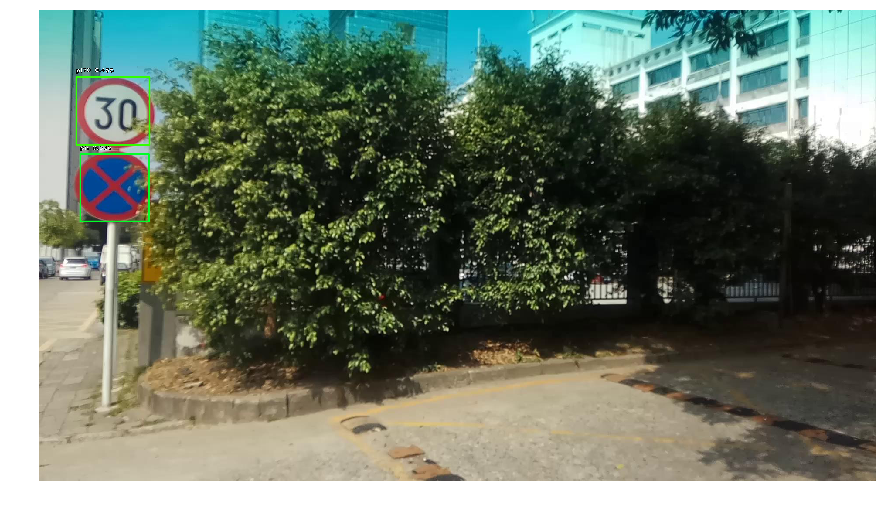

('processing time: ', 0.1849498748779297)


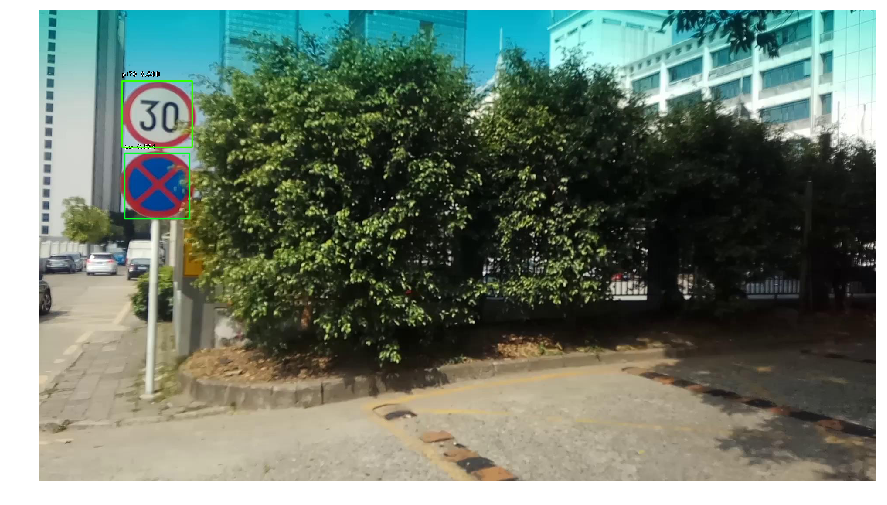

('processing time: ', 0.1847238540649414)


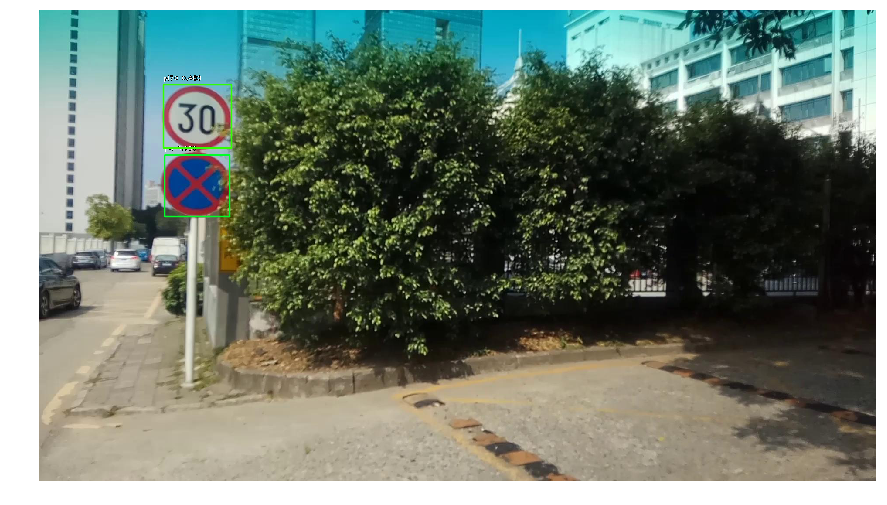

('processing time: ', 0.1900041103363037)


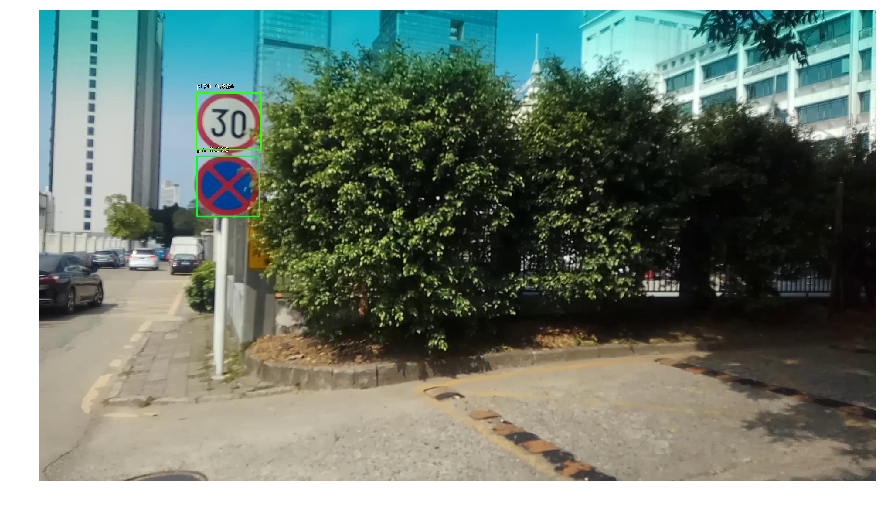

('processing time: ', 0.1774599552154541)


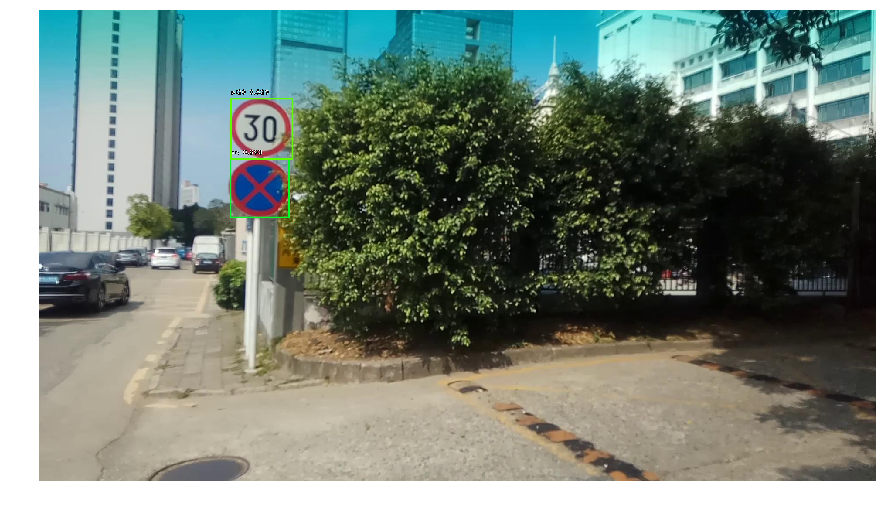

('processing time: ', 0.19652891159057617)


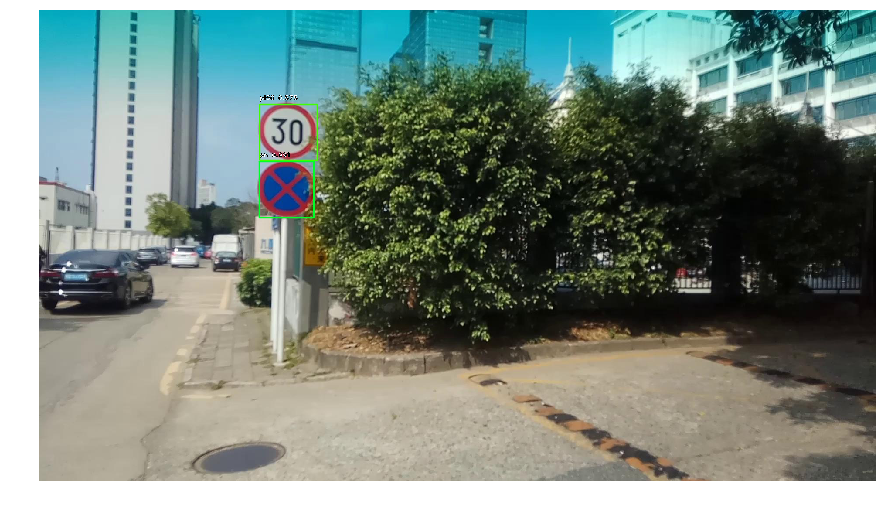

('processing time: ', 0.18598508834838867)


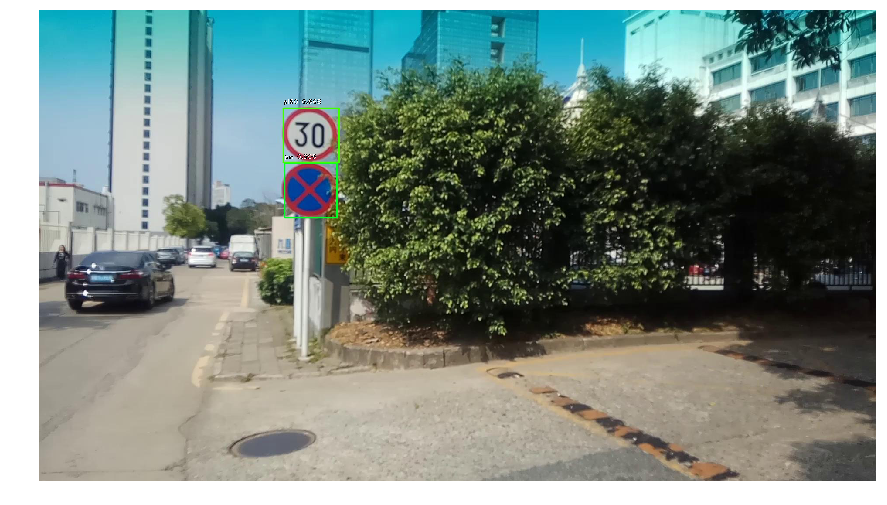

('processing time: ', 0.185837984085083)


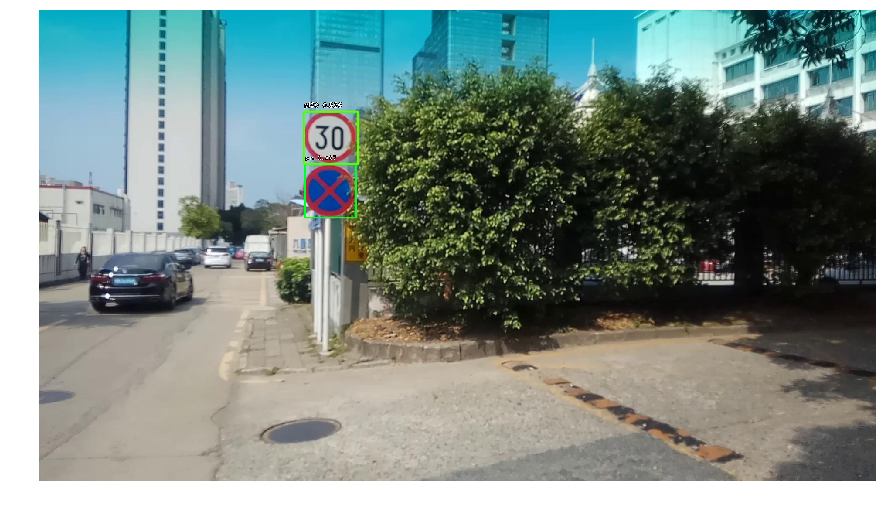

('processing time: ', 0.19224905967712402)


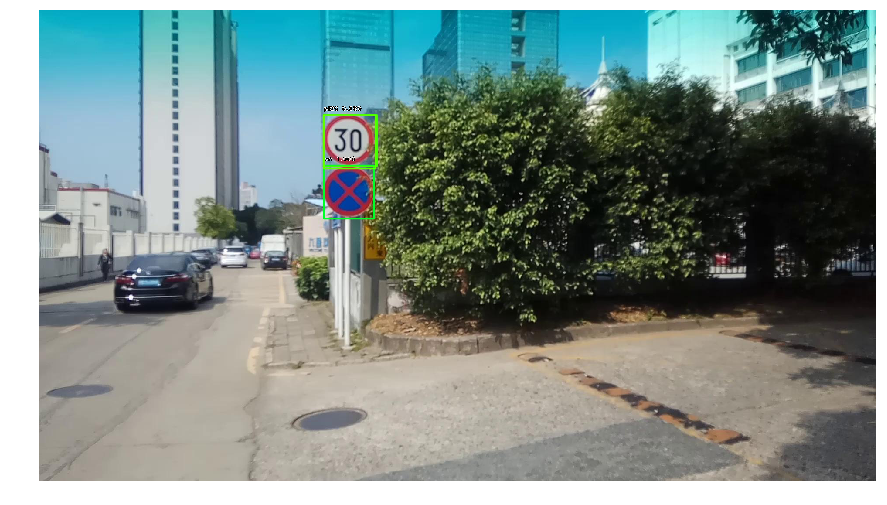

('processing time: ', 0.18430614471435547)


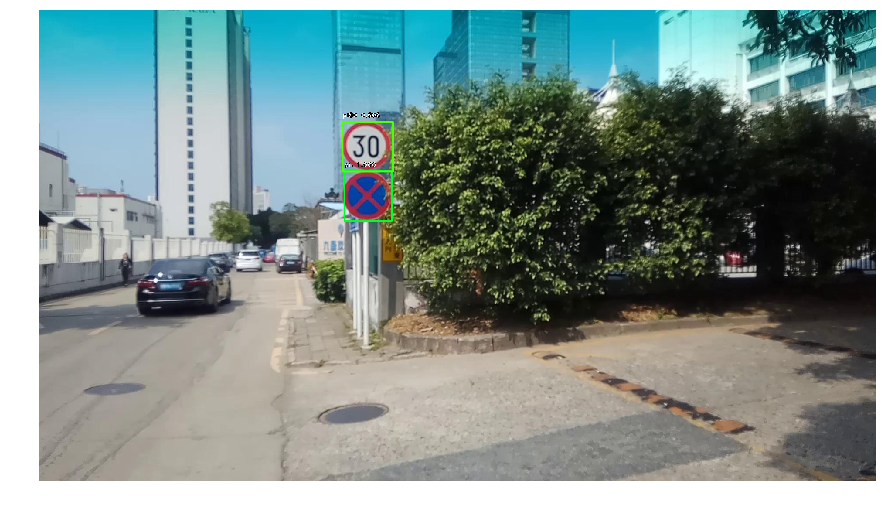

In [123]:
# load image
# image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
# from random import shuffle
# image_folder = '/data/a2301133/TT100K/data/test/'
image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
file_name = 'SF_770_NEW.txt'
# image_folder = '/data/a2301133/SF/SF_2018-02-06_09-31-29-672/2018-02-06_09-31-29-672_cam/'
# file_name = 'SF_672_NEW.txt'
# image_folder = '/data/a2301133/SF/SF_2018-01-26_10-44-55-445/2018-01-26_10-44-55-445_cam/'
# file_name = 'SF_445_NEW.txt'

data = pd.read_csv(image_folder + file_name, sep = "\t", header = 0)
data = data[['File','X','Y','Width','Height','SignClass']]
# image_files = [x for x in os.listdir(image_folder) if '.jpg' in x]
# shuffle(image_files)
# image_files = [image_files[i] for i in xrange(len(image_files)) if i <= 10]

for i in range(len(data)):
    image = read_image_bgr(image_folder + data.iloc[i][0])
    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < 0.45:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

In [128]:
from collections import deque
image_folder = '/data/a2301133/SF/SF_2018-03-07_10-43-46-770/2018-03-07_10-43-46-770/'
file_name = 'SF_770_NEW.txt'
data = pd.read_csv(image_folder + file_name, sep = "\t", header = 0)
data = data[['File','X','Y','Width','Height','SignClass']]
threshold = 0.45
for i in range(3):
    image = read_image_bgr(image_folder + data.iloc[i][0])
    image = preprocess_image(image)
    image, scale = resize_image(image)
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis = 0))
    boxes /= scale
    l_boxes, l_scores, l_labels = [], [], []
    for j in range(len(scores[0])):
        if scores[0][j] <= threshold:
            l_scores = scores[0][0 : j]
            l_boxes = boxes[0][0 : j].astype(int)
            l_labels = labels[0][0 : j]
            break
    for k in range(len(l_labels)):
        print labels_to_names.get(l_labels[k])

pn
pl70
pn
pl70
pn
pl70


In [127]:
data[0:3]

File    X    Y  Width  Height SignClass
0  0008892.jpg   78  323    187     166        pn
1  0008891.jpg  181  332    173     143        pn
2  0008890.jpg  274  333    171     143        pn

In [115]:
l_boxes

array([[ 94, 330, 252, 484],
       [ 85, 153, 253, 309],
       [ 83, 160, 266, 312]])

In [ ]:
x, y = model.predict_on_batch(np.expand_dims(image, axis=0))

In [18]:
data

File     X    Y  Width  Height SignClass
0     0008892.jpg    78  323    187     166        pn
1     0008891.jpg   181  332    173     143        pn
2     0008890.jpg   274  333    171     143        pn
3     0008889.jpg   350  340    153     127        pn
4     0008888.jpg   427  350    147     130        pn
5     0008887.jpg   493  350    147     129        pn
6     0008886.jpg   550  357    139     120        pn
7     0008885.jpg   598  362    128     115        pn
8     0008884.jpg   644  364    129     117        pn
9     0008883.jpg   688  376    120     108        pn
10    0008882.jpg   723  380    117     105        pn
11    0008881.jpg   754  378    111     103        pn
12    0008880.jpg   785  384    109     100        pn
13    0008879.jpg   818  390    105      96        pn
14    0008878.jpg   840  396    105      92        pn
15    0008877.jpg   870  396    108      93        pn
16    0008876.jpg   896  391    104      89        pn
17    0008875.jpg   914  403     99      86        pn
18    0008874.jpg   931  415     96      82        pn
19    0008873.jpg   948  414     92      79        pn
20    0008872.jpg   965  412     97      85        pn
21    0008871.jpg   980  415     93      81        pn
22    0008870.jpg   990  416     90      78        pn
23    0008869.jpg  1009  422     86      75        pn
24    0008868.jpg  1014  431     83      75        pn
25    0008867.jpg  1042  421     76      77        pn
26    0008866.jpg  1039  428     83      75        pn
27    0008865.jpg  1052  435     80      72        pn
28    0008864.jpg  1058  436     76      70        pn
29    0008863.jpg  1081  437     73      67        pn
...           ...   ...  ...    ...     ...       ...
1838  0003874.jpg  1672  131    103      92       w65
1839  0003873.jpg  1599  182     93      83       w65
1840  0003872.jpg  1538  208     84      75       w65
1841  0003871.jpg  1490  234     76      68       w65
1842  0003870.jpg  1452  265     70      62       w65
1843  0003869.jpg  1414  283     68      63       w65
1844  0001466.jpg  1464   35    215     178       w20
1845  0001465.jpg  1369   97    187     154       w20
1846  0001464.jpg  1306  130    159     135       w20
1847  0001463.jpg  1264  173    137     117       w20
1848  0001462.jpg  1237  198    129     110       w20
1849  0001461.jpg  1206  254    112      96       w20
1850  0001460.jpg  1190  301    101      86       w20
1851  0001459.jpg  1164  302     92      78       w20
1852  0001458.jpg  1146  308     83      71       w20
1853  0001457.jpg  1135  319     76      65       w20
1854  0001456.jpg  1118  331     72      61       w20
1855  0001455.jpg  1116  344     68      58       w20
1856  0001454.jpg  1094  366     62      53       w20
1857  0001453.jpg  1095  376     59      50       w20
1858  0001452.jpg  1086  392     55      47       w20
1859  0001451.jpg  1078  397     52      44       w20
1860  0001450.jpg  1073  400     50      43       w20
1861  0001449.jpg  1060  403     47      45       w20
1862  0000917.jpg  1103    1    174     139       w13
1863  0000916.jpg  1079   16    163     143       w13
1864  0000915.jpg  1058   34    155     138       w13
1865  0000914.jpg  1038   50    153     134       w13
1866  0000913.jpg  1020   67    150     131       w13
1867  0000912.jpg   999   83    146     127       w13

[1868 rows x 6 columns]